In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-classification-64-classes-animal:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5659763%2F9339402%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240929%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240929T175540Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D26a0fc4e186fd50f4e79e7d1859ee31ba80348a6b0d4b3b05982b94b1a148880409c2c23c40ab1ff84e5cb3463be77b0fd692b8ee52316d4a6542cfece5b88599c55a9d7611e3d4acfacd94cafaee8b78e1c856caaee224fd22be6a34fe50c6094b501b88c5c8741b6474d57e11ade9bab392a46e653e89fbe90f16522fe2aa34dc16a4523faba8d6e23ee4b7357e829bac24814c607705ebc07f3a961e98c9cd61efdd3c6145e49331fe94466de0d1f757fd74bf22e322185d5ed85d89f8c59e232891246a28559163e7b40a5c7cfc3609638717a552f5bb721079b2e92b2e13191665f260c3b92ab757d151faf47116fbc23ad8221a8b16937247803608079'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6135223223 bytes downloaded
Downloaded and uncompressed: image-classification-64-classes-animal
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
data_directory= "/kaggle/input/image-classification-64-classes-animal/image"
import tensorflow as tf

import sklearn
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [8]:
datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,  # Rotate images by up to 20 degrees
        width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
        height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
        shear_range=0.2,  # Apply shear transformations
        zoom_range=0.2,  # Zoom in or out by up to 20%
        horizontal_flip=True,  # Flip images horizontally
        fill_mode='nearest',
        validation_split=0.2)
train_ds=datagen.flow_from_directory(
        directory=data_directory,
        batch_size=32,
        subset='training',
        target_size=(150,150),
        class_mode='categorical'

)
validation_ds=test_ds=datagen.flow_from_directory(
        directory=data_directory,
        batch_size=32,
        subset='validation',
        target_size=(150,150),
        class_mode='categorical'

)

Found 11515 images belonging to 64 classes.
Found 2862 images belonging to 64 classes.


In [17]:
species = os.listdir(data_directory)
species

['beaver',
 'jaguar',
 'seal',
 'goose',
 'owl',
 'peacock',
 'penguin',
 'bison',
 'snake',
 'whale',
 'ferret',
 'bear',
 'chimpanzee',
 'dolphin',
 'duck',
 'dog',
 'ostrich',
 'porcupine',
 'leopard',
 'lynx',
 'cat',
 'kangaroo',
 'hawk',
 'koala',
 'iguana',
 'raccoon',
 'squid',
 'grasshopper',
 'cow',
 'cheetah',
 'fox',
 'frog',
 'goat',
 'deer',
 'crab',
 'hyena',
 'bee',
 'eagle',
 'hippopotamus',
 'crocodile',
 'panda',
 'elephant',
 'mole',
 'gorilla',
 'camel',
 'buffalo',
 'spider',
 'giraffe',
 'hedgehog',
 'mongoose',
 'flamingo',
 'blackbird',
 'donkey',
 'falcon',
 'otter',
 'antelope',
 'sheep',
 'chinchilla',
 'walrus',
 'butterfly',
 'lizard',
 'snail',
 'lemur',
 'wolf']

In [18]:
species_images = {}
for specie in species:
    species_images[specie] = os.listdir(f"/kaggle/input/image-classification-64-classes-animal/image/{specie}")
for specie in species_images:
    print(f"Dataset contains {len(species_images[specie])} images of {specie}")

Dataset contains 216 images of beaver
Dataset contains 186 images of jaguar
Dataset contains 216 images of seal
Dataset contains 216 images of goose
Dataset contains 216 images of owl
Dataset contains 216 images of peacock
Dataset contains 216 images of penguin
Dataset contains 216 images of bison
Dataset contains 216 images of snake
Dataset contains 216 images of whale
Dataset contains 216 images of ferret
Dataset contains 216 images of bear
Dataset contains 216 images of chimpanzee
Dataset contains 216 images of dolphin
Dataset contains 216 images of duck
Dataset contains 456 images of dog
Dataset contains 216 images of ostrich
Dataset contains 216 images of porcupine
Dataset contains 216 images of leopard
Dataset contains 216 images of lynx
Dataset contains 432 images of cat
Dataset contains 216 images of kangaroo
Dataset contains 216 images of hawk
Dataset contains 216 images of koala
Dataset contains 216 images of iguana
Dataset contains 216 images of raccoon
Dataset contains 215 

In [19]:
df = pd.DataFrame({"species": [k for k,li in species_images.items() for image in li], "image": [image for k,li in species_images.items() for image in li]})
df

species                 image
0      beaver  08571-3693399842.png
1      beaver  08463-3693399734.png
2      beaver  08509-3693399780.png
3      beaver  08532-3693399803.png
4      beaver  08568-3693399839.png
...       ...                   ...
14372    wolf   08227-688626738.png
14373    wolf   08344-688626855.png
14374    wolf   08365-688626876.png
14375    wolf   08291-688626802.png
14376    wolf   08313-688626824.png

[14377 rows x 2 columns]

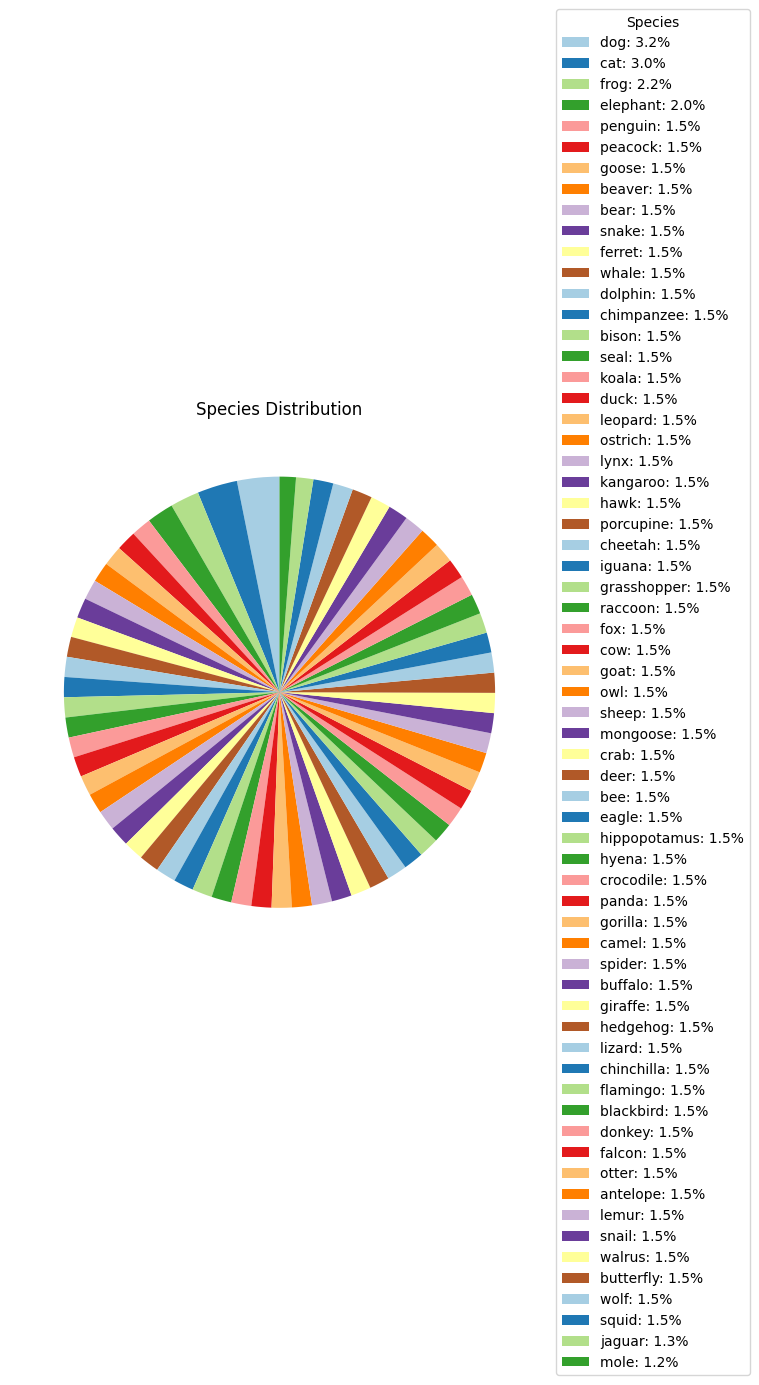

In [20]:
value_counts = df['species'].value_counts()

# Calculate the percentage for each category
percentages = 100 * value_counts / value_counts.sum()

# Plot pie chart without labels on the pie
plt.figure(figsize=(7, 7))
plt.pie(value_counts, startangle=90, colors=plt.cm.Paired.colors)

# Add title
plt.title('Species Distribution')

# Create a separate table of labels with percentages
labels = [f'{species}: {percentage:.1f}%' for species, percentage in zip(value_counts.index, percentages)]

# Add the labels as a legend
plt.legend(labels, title="Species", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the plot
plt.show()


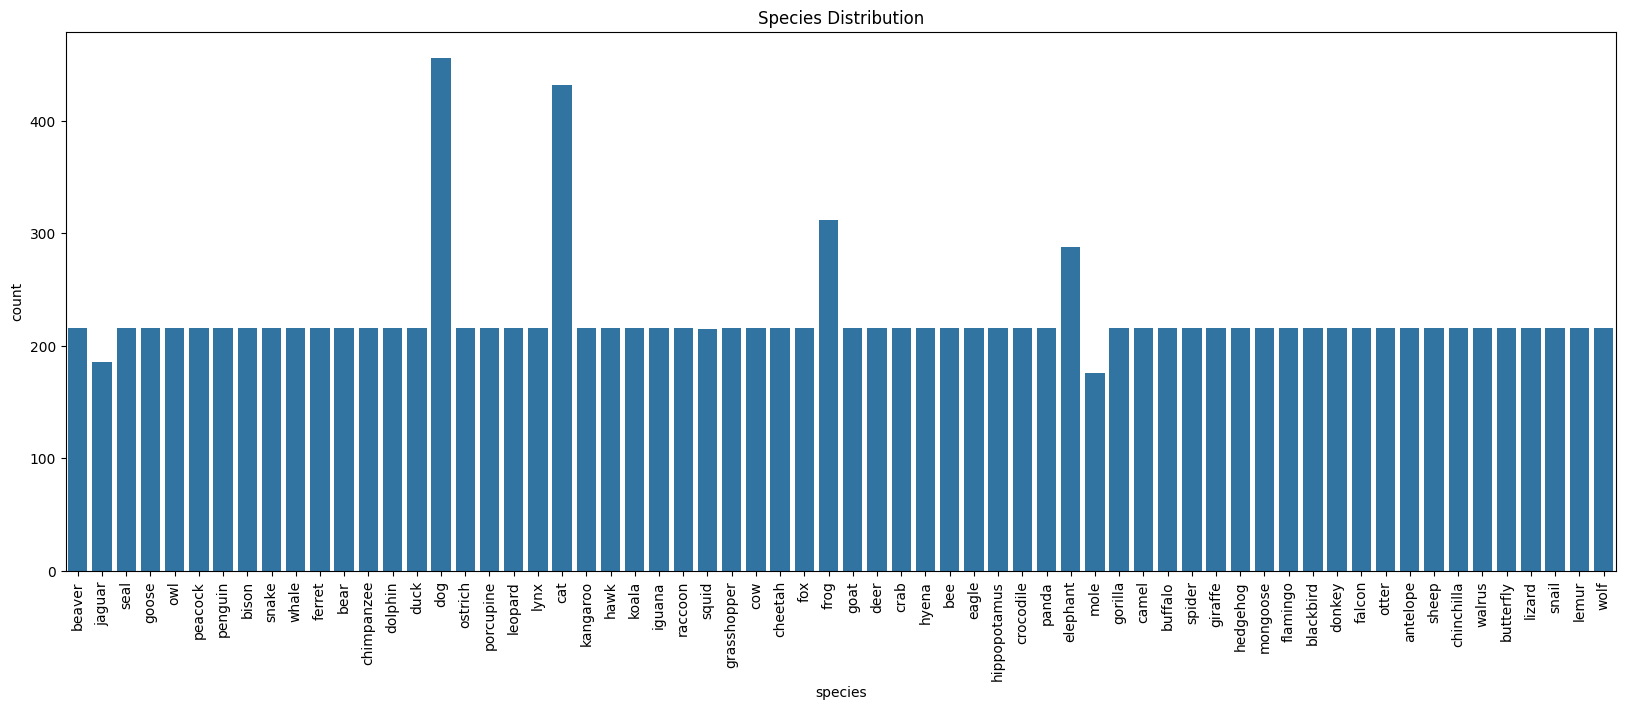

In [21]:
import seaborn as sns
plt.figure(figsize=(20,7))
sns.countplot(df, x='species')
plt.xticks(rotation=90)
plt.title("Species Distribution")
plt.show()

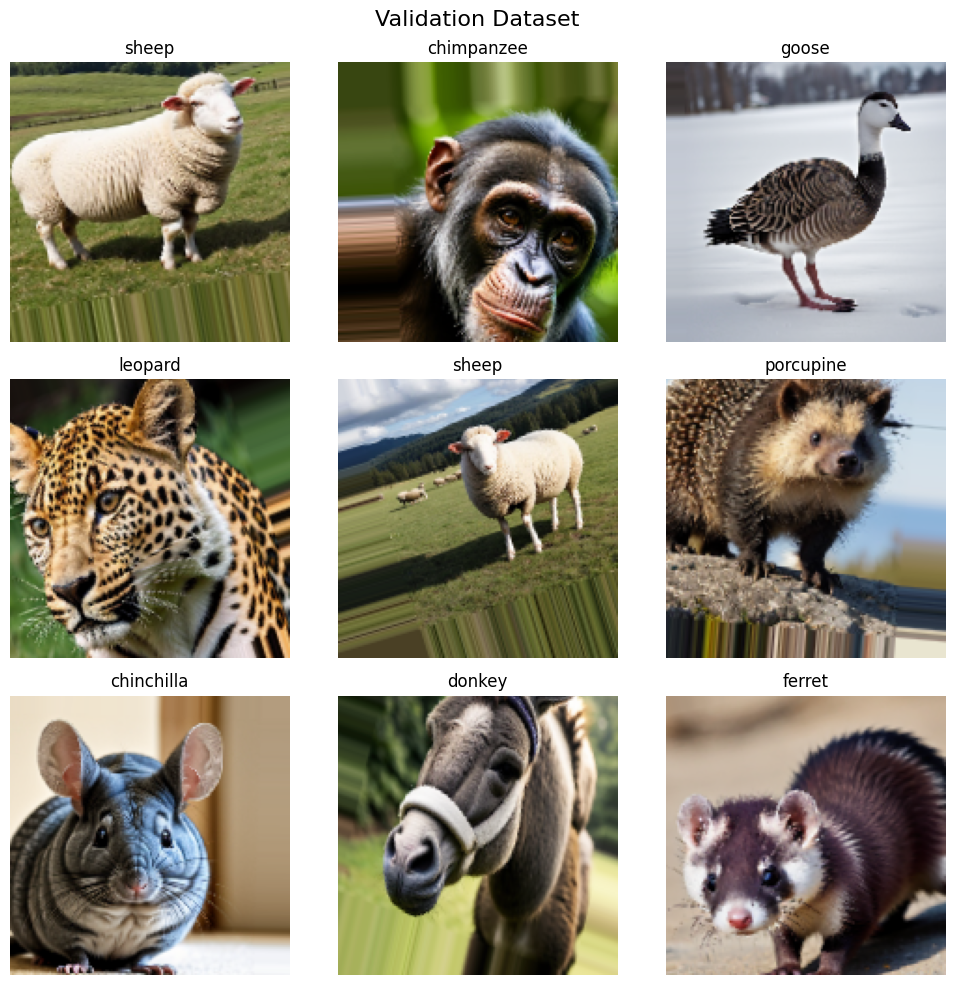

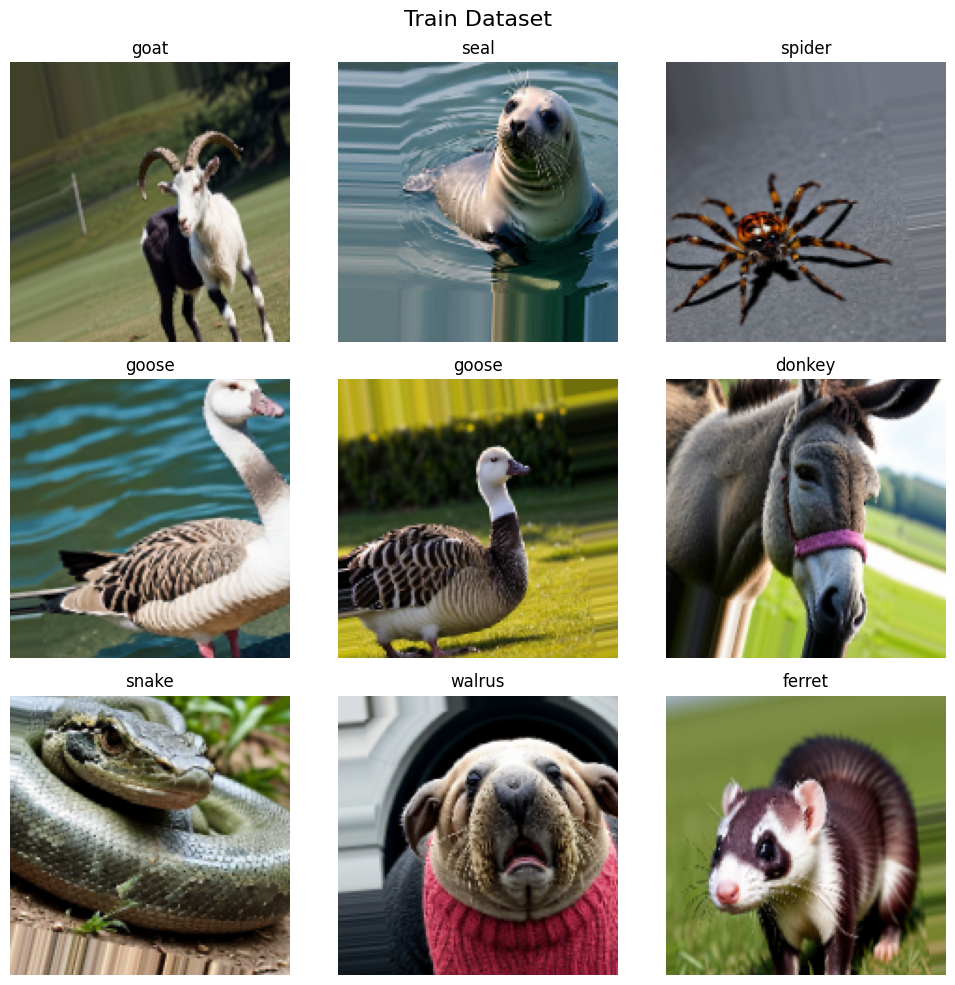

In [23]:
def visualize_augmented_images(generator, suptitle):
    # Get a batch of images from the generator
    images, labels = next(generator)
    label_map = list(generator.class_indices.keys())

    # Create a 3x3 grid to display images
    plt.figure(figsize=(10, 10))
    plt.suptitle(suptitle, fontsize=16)
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.title(label_map[np.argmax(labels[i])])
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_augmented_images(validation_ds, "Validation Dataset")
visualize_augmented_images(train_ds, "Train Dataset")

In [10]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(150,150,3))
# Freeze the base model layers
for layer in base_model.layers[-10:]:
    layer.trainable = True
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(64,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

In [12]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=3,              # Number of epochs to wait for improvement
    restore_best_weights=True )
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']


)
history=model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    verbose=1,
    callbacks=[early_stopping]

)

Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 421s 945ms/step - accuracy: 0.7388 - loss: 1.2236 - val_accuracy: 0.0287 - val_loss: 4.1819
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 313s 853ms/step - accuracy: 0.9794 - loss: 0.0736 - val_accuracy: 0.3232 - val_loss: 2.8857
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 275s 753ms/step - accuracy: 0.9813 - loss: 0.0615 - val_accuracy: 0.9546 - val_loss: 0.1646
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 271s 744ms/step - accuracy: 0.9904 - loss: 0.0366 - val_accuracy: 0.9832 - val_loss: 0.0719
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 319s 736ms/step - accuracy: 0.9908 - loss: 0.0319 - val_accuracy: 0.9867 - val_loss: 0.0473
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 264s 725ms/step - accuracy: 0.9895 - loss: 0.0410 - val_accuracy: 0.9724 - val_loss: 0.1011
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 294s 808ms/step - accuracy: 0.9897 - loss: 0.0357 - val_accuracy: 0.9668 - val_loss: 0.1315
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 291s 721ms/step - accuracy: 0.9900 -

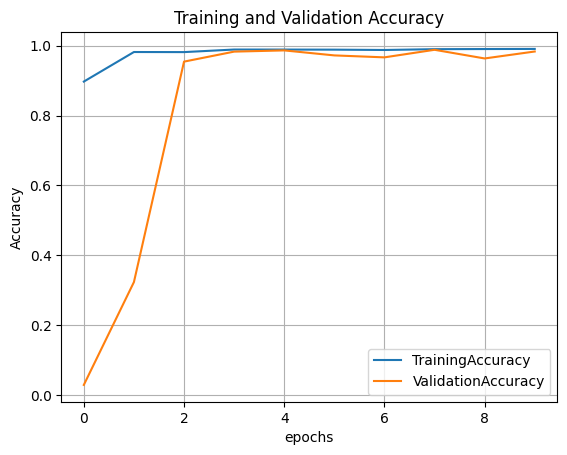

In [14]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(acc,label='TrainingAccuracy')
plt.plot(val_acc,label='ValidationAccuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 531ms/step - accuracy: 0.9905 - loss: 0.0423
Test Loss: 0.035105615854263306
Test Accuracy: 99.05660152435303


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


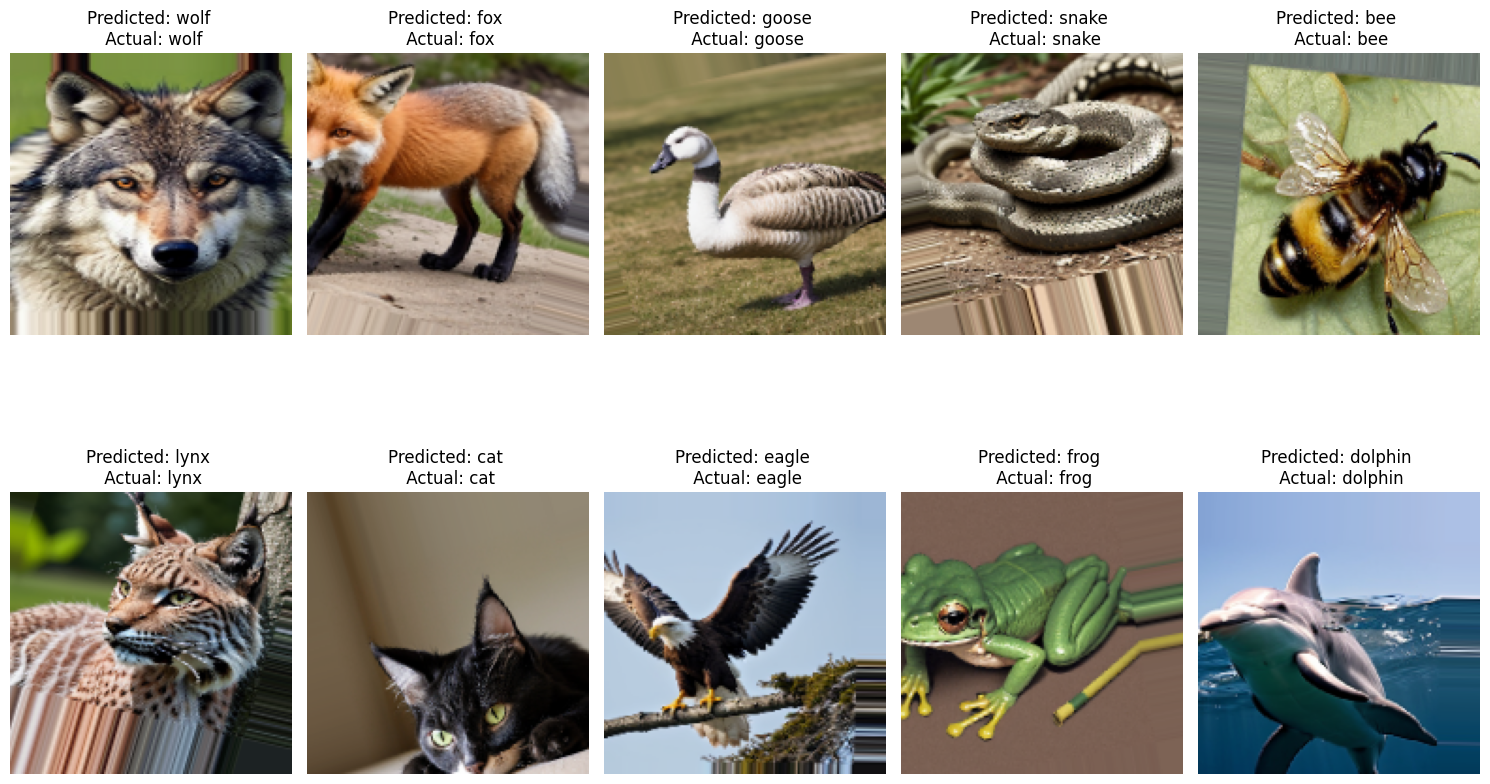

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the validation dataset
images, true_labels = next(validation_ds)

# Make predictions on the images
predicted_labels = model.predict(images)

# Get the class labels from the ImageDataGenerator
class_labels = list(validation_ds.class_indices.keys())

# Display 10 images with predicted and actual labels
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Predicted: {class_labels[np.argmax(predicted_labels[i])]} \n Actual: {class_labels[np.argmax(true_labels[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()